# Reconstructies op een hemelkaart
In dit notebook worden de richtingen van deeltjeslawines bepaald en geplot op een projectie van de (sterren)hemel.

In [1]:
# dit notebook werkt onder Python 2 en 3
from __future__ import division, print_function

In [2]:
import os
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tables
from sapphire import download_coincidences, ReconstructESDCoincidences, ScienceParkCluster
from sapphire.utils import pbar
from sapphire.transformations.celestial import zenithazimuth_to_equatorial

## Download data
Download coincidenties tussen stations van het Science Park.
We nemen coincidenties tussen negen stations in een periode van een maand.
Door deze keuze selecteren we een beperkt aantal showers met hoge energie.

In [3]:
DATAFILE = '../Datastore/large_coinc.h5'
STATIONS = [501, 502, 503, 505, 506, 508, 509, 510, 511]
START = datetime(2016, 1, 1)
END = datetime(2016, 2, 1)

In [4]:
import tables
data = tables.open_file(DATAFILE, 'w')

In [5]:
download_coincidences(data, stations=STATIONS, start=START, end=END, n=9)

100%|####################################################################################################|Time: 0:00:06


In [20]:
print("Aantal showers (coincidenties n=9 stations): ", len(data.root.coincidences.coincidences))

Aantal showers (coincidenties n=9 stations):  257


## Reconstrueer richting van de showers
Reconstrueer en verwijder showers waarvan de richting niet gereconstrueerd konden worden (Zowel de zenit-hoek als azimut van die showers is NaN).

In [7]:
rec = ReconstructESDCoincidences(data, overwrite=True)
rec.reconstruct_and_store()

100%|####################################################################################################|Time: 0:00:12
100%|####################################################################################################|Time: 0:00:01


In [8]:
recs = data.root.coincidences.reconstructions.read()
theta = recs['zenith']
recs = recs.compress(~np.isnan(theta))

Maak een histrogram van de zenit-hoeken om de kwaliteit van de data te onderzoeken:

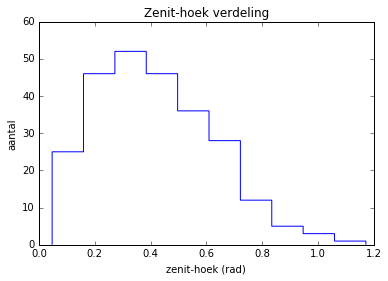

In [9]:
plt.hist(recs['zenith'], histtype='step')
plt.title('Zenit-hoek verdeling')
plt.xlabel('zenit-hoek (rad)')
plt.ylabel('aantal')
plt.show()

## Coordinatentransformatie naar rechte-klimming en declinatie

De richting van de events (`zenit-hoek` en `azimut` ten opzicht van een ENU-assenstelsel in het cluster) wordt getransformeerd naar rechte klimming en declinatie.

Voor de coordinatentransformatie naar rechte-klimming en declinatie is de positie van ENU-assenstelsel van het cluster nodig:

In [10]:
lla = ScienceParkCluster().get_lla_coordinates()
lat, lon, alt = lla
print(lat, lon)

52.3558991 4.950988


Reken elk event om naar rechte klimming (RA) en declinatie (DEC). En schaal deze naar (-pi, pi) voor het plotten. Sla de RA,DEC paren op in de lijst `events`

In [11]:
events = []
for rec in pbar(recs):
    timestamp = rec['ext_timestamp'] / 1.e9
    theta = rec['zenith']
    phi = rec['azimuth']
    r, d = zenithazimuth_to_equatorial(lat, lon, timestamp, theta, phi)
    events.append((r-np.pi, d))
events = np.array(events)

100%|####################################################################################################|Time: 0:00:00


Histrogram ter controle:

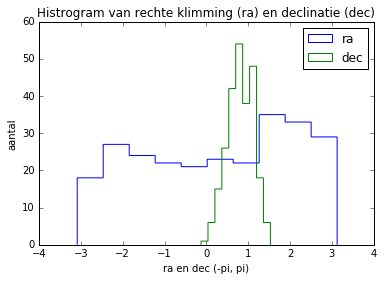

In [12]:
ra = events[:,0]
dec = events[:, 1]
plt.title('Histrogram van rechte klimming (ra) en declinatie (dec)')
plt.hist(ra, histtype='step')
plt.hist(dec, histtype='step')
plt.xlabel('ra en dec (-pi, pi)')
plt.ylabel('aantal')
plt.legend(['ra', 'dec'])
plt.show()

# Definitie van plots

Hier worden de plot functies `plot_events_on_mollweide()` en `plot_events_polar()` gedefinieerd.

In [13]:
# RA, DEC tuples van het steelpan asterisme in het sterrenbeeld Grote Beer
steelpan = np.array([[13.792222, 49.3167], [13.398889, 54.9333], [12.900556, 55.95],
                     [12.257222, 57.0333], [11.896944, 53.7000], [11.030833, 56.3833],
                     [11.062222, 61.7500], [12.257222, 57.0333]])
# Melkweg contouren als lijst van RA, DEC paren.
# `milky_way.npy` heeft *geen* verbinding tussen RA 23h59 en 0h00 en `milky_way_polar.npy` wel.
if os.path.exists('milky_way.npy'):
    mw_contour = np.load('milky_way.npy') 
    mw_contour_polar = np.load('milky_way_polar.npy')
else:
    mw_contour = mw_contour_polar = []

In [14]:
def plot_events_on_mollweide(events, filename=None):
    """Plot events (een lijst van RA, DEC tuples) op een kaart in Mollweide projectie"""
    
    events = np.array(events)
    
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection="mollweide")
    ax.set_xticklabels(['2h', '4h', '6h', '8h', '10h', '12h', '14h', '16h', '18h', '20h', '22h'], fontsize='large')
    ax.grid(True)
    
    # plot milky way contours
    for ra_mw, dec_mw in mw_contour:
        ax.plot(ra_mw, dec_mw, color='grey')
    
    # plot steelpan in UMa
    ra_uma = np.radians(steelpan[:, 0] / 24 * 360 - 180.)
    dec_uma = np.radians(steelpan[:, 1])
    ax.plot(ra_uma, dec_uma, color='red')
    ax.scatter(ra_uma, dec_uma, color='red')
    # plot Polaris
    ax.scatter(0., np.radians(90), color='red')
    
    # plot reconstructions
    ax.scatter(events[:,0], events[:,1], marker='x')
    if filename:
        plt.savefig(filename, dpi=200)

In [18]:
def plot_events_polar(events, filename=None):
    """Plot events (een lijst van RA, DEC paren) op een hemelkaart van de noordelijke hemel"""

    events = np.array(events)

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection="polar")
    ax.set_xticklabels(['12h', '15h', '18h', '21h', '0h', '3h', '6h', '9h'], fontsize='large')
    ax.set_yticklabels(['80', '70', '60', '50', '40', '30', '20', '10', '0'])

    ax.grid(True)
    
    # plot milky way contours
    for ra_mw, dec_mw in mw_contour_polar:
        ax.plot(ra_mw, 90. - np.degrees(dec_mw), color='grey')

    # plot UMa
    ra_uma = np.radians(steelpan[:, 0] / 24 * 360 - 180.)
    dec_uma = np.radians(steelpan[:, 1])
    ax.plot(ra_uma, 90. - np.degrees(dec_uma), color='red')
    ax.scatter(ra_uma, 90. - np.degrees(dec_uma), color='red')
    # plot Polaris
    ax.scatter(0., 0., color='red')

    # plot reconstructions
    ax.scatter(events[:,0], 90. - np.degrees(events[:,1]), marker='x')
    ax.set_rmax(90.0)
    if filename:
        plt.savefig(filename, dpi=200)
    plt.show()

# Maak plots

C:\Miniconda3\envs\py3\lib\site-packages\matplotlib\projections\geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


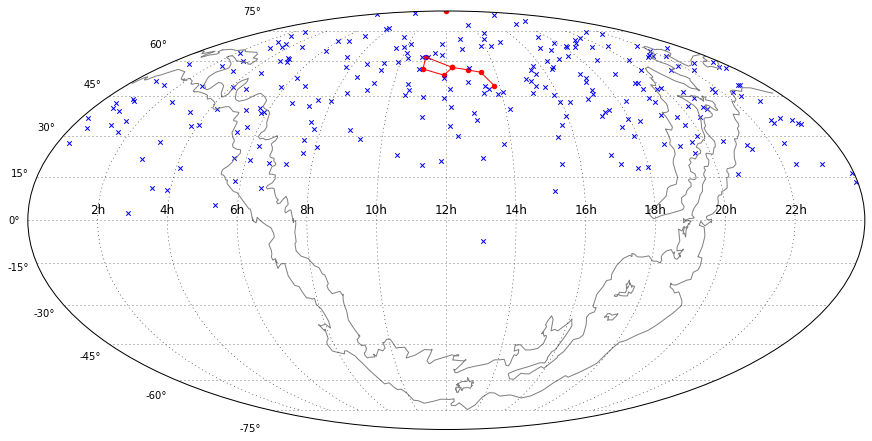

In [16]:
plot_events_on_mollweide(events)

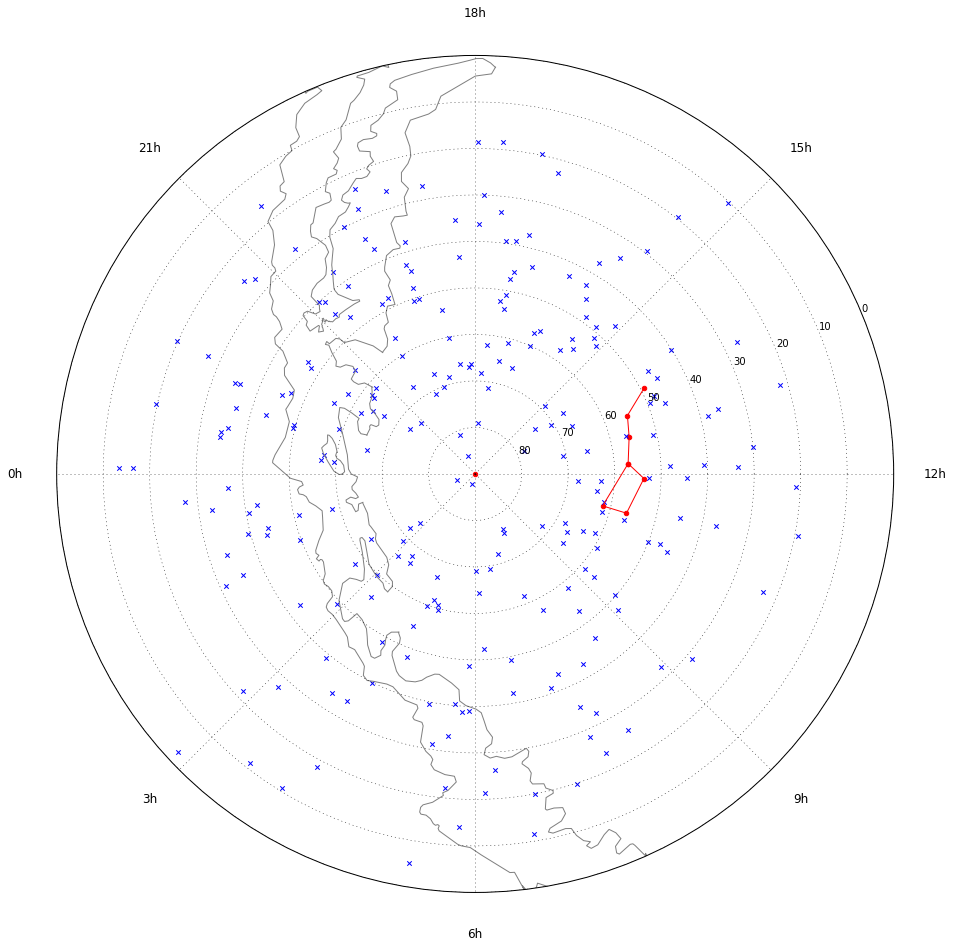

In [19]:
plot_events_polar(events)